## Project Summary for Predicting Importance of Research Articles from Past Data.
### Capstone Project for The Data Incubator

In [1]:
import os
os.getcwd()

'C:\\Users\\bcyk5\\OneDrive\\Documents\\GitHub\\citation_prediction_from_google_scholar'

In [2]:
from IPython.display import Image

#### The product is a model which can prioritize a reading list from recently published literature, the importance of recently published articles is predicted using past articles

If 10,000 papers on a topic are published per year (the case for my field during my PhD), then you'd need to skim the metadata and abstracts of ~28 papers per day, every day, to decide what to read.

This work is partially motivated by a near miss I had while working in a previous role, where my daily reading caught a paper which changed the research direction of the company. If it had been a busier week, or I was tired / distracted, this update could have been missed.

In hindsight, this paper should have been obvious given the authors, journal, and title, but I was the only one at the company who (mostly by luck) caught it. A machine can be much relaiable than a human for spotting these type of important updates based on their metadata. As the pace of innovation accelerates, delays catching crucial updates and incoproating them into an organizations plan cost time and money

In this project, a model is trained which predicts the number of citations of a paper which is too recent to have a record of citations.

The idea is to filter out unimportant papers from a large amount of papers and give the user concise reading list of only the ones which are likely to be important, as measured by the predicted number of citations. This concept is illustrated below.


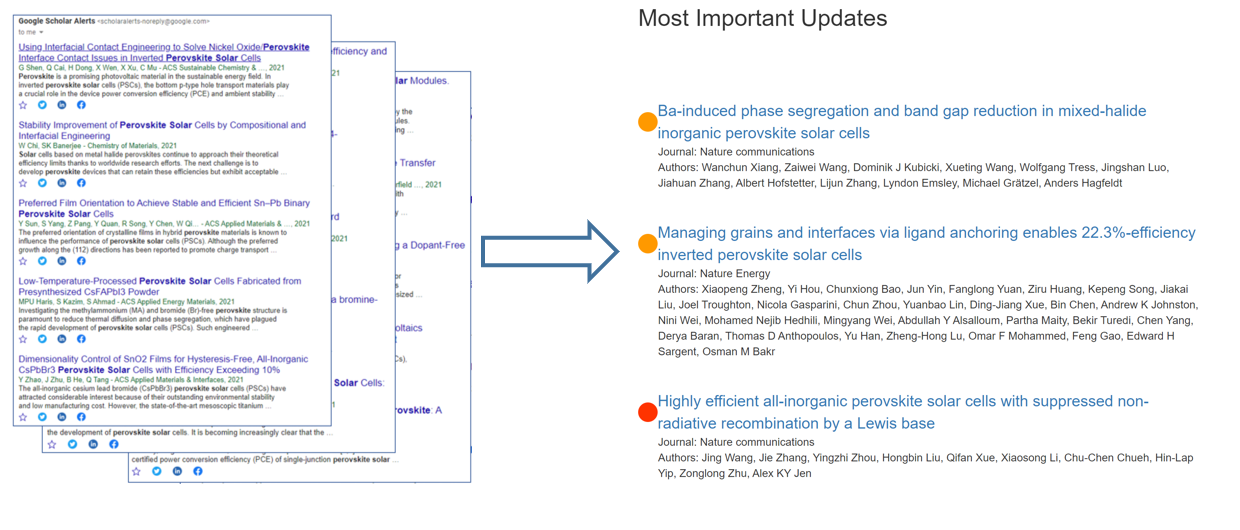

In [4]:
Image(filename='images\\updates to filtered updates.png') 

## Explanation of the Data Mining Process
The data needed to acheive this goal can be found using google scholar, a tool which allows allows the user to search 
literature veiw article meterics like citations. Most researchers have a google scholar page which lists all of their
articles, and has detailed metadata abount those articles. For each article, the number of citations (importance) and 
articles cited it are available. The network of citations forms a directed acyclic graph, as an article may only cite 
articles which came before it. By crawling this network of citations, it's possible to explore a topic are (such as
machine learning or solar energy) and obtain a list of articles in that topic and how wrote them. In the data mining 
scheme outlined below, articles and authors are discovered by crawling the citation network, and the detailed metadata 
is obtained by scrapping an google scholar page

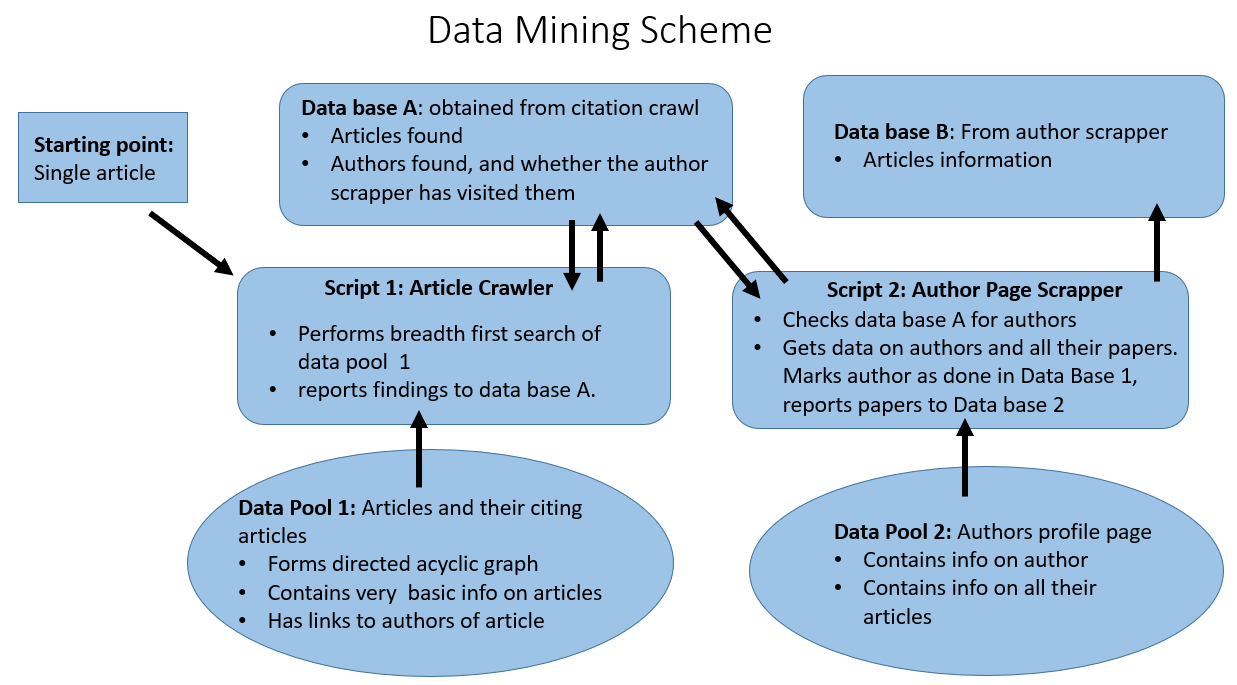

In [7]:
Image(filename='images\\data mining scheme.png') 

The sqlite databases keep track of where scripts 1 and 2 have been, so any number of these scripts can be run in parallel.
When doing the data mining, between 10 and 20 instances of each script were active.
For script 1, multiple starting points are used to spawn multiple searches. Instances for script 2 were created by a script,
and the number was kept below a threshold (~15) to avoid being flagged and hit with a captacha.
The detailed data found by the scripts was saved to disk, not the actual sql tables. See the "data mining folder" for more details

The scripts ran (fairly) unattended for a month, collecting ~10 million articles and 1 million authors. This is a larger
data set than the computational resources available can handle, so a subset of articles on solar energy 
was selected as a demonstration. I am familair with many of these papers and their metadata, and so am more likely to spot instances of where imporant information is missed by the crawlers, or when the ML model is performing poorly.

### Dataset Used for Modelling
The subset was selected by searching through all articles and returning only those with certain key words related to solar energy. This subset was then used to create a subset of all authors, and each paper from every author who had a solar energy paper was fetched. This gave a dataset where the articles shared enough attibutes that it was possible to make meaningful predictions. Randomly grabing grabbing 100k papers from the 10 million would likely give a articles which share few attributes(different topics, authors, journals, etc, making it difficult to find any meaningful signal becase each attribute would have a small number of articles)

In [12]:
def get_subset(dir_code: str, locations: list, key_words: list, file_name: str) -> None:
    ''' Select a subset of the articles based on the presence of keywords
    
        Parameters
        ----------
        dir_code : str
            The function only looks in a dir if the name contains this string, used to select which dirs to check.
        locations : list
            Tells the function which data fields in which to look for the keywords, 'all' searches all all text scrapped for 
            that article.
        key_words : list
            The keywords to search for, any article with any one of these words in any one of 'locations' will placed in
            the output file.
        file_name : str
            The name of the output csv file.

        Returns
        -------
        None, the is output saved to disk as csv.

    NOTE: functions called here are in select_sub_set.py

    '''

    
    out_dir = "data_subset\\" # output dir is hardcoded in
    
    main_dir = "C:\\Users\\bcyk5\\OneDrive\\Documents\\ds projects big data\\get citations google scholar\\parallel scrape paper graph and author\\test1\\"
    cur_dir = os.getcwd()
    
    # get the directories which will to be checked for articles with matching keywords. The "outputs" subfolder is where 
    # each instance of a scrapper dumps its results
    dirs_to_read = getPaths(main_dir, dir_code, "outputs") 
    
    # The order in which the columns will appear in the df
    col_names = {"titleID": 0, "title_main": 1, "cited": 2, "Authors": 3, "pubDate": 4, \
            "Journal": 5, "Conference": 6, "Source": 7, "book":8, "vol": 9, "issue": 10, "pages": 11, "publisher": 12, \
            "description": 13, "citedYear": 14, "scrap_auth_id": 15, "urlID": 16, \
            "all": 17}
    # data fields to keep when the df is cleaned. if not present ignored.
    cols_to_return = ['titleID',"title_main", 'Authors', 'Journal', "Conference", "Source", "book", \
                   'publisher', "vol", "issue", 'year', "pages", 'cited_num', \
               'cites_per_year', 'date', 'scrap_auth_id', "citedYear", "urlID", 'abstract']
        
    # Meta data fields to retrieve from the disk for each paper
    keysToGet = set(['titleID', 'cited', 'authors', 'authors', 'pubDate', 'journal', 'abstract'])
    
    # get all the articles with the desired keywords.
    papers = load_dicts_from_dir_to_list_condition("paperDictA", dirs_to_read, col_names, key_words, locations)

    df = paperlist_to_df(papers)
    """ use apply to get the abstract text from all, create abstract column. This is a hacky way around a formatting bug from earlier in the project
    """
    # test paper gone at this point
    df['abstract'] = df.apply(get_abstract, axis = 1)
    df = clean_df(df, cols_to_return) # more ad hoc cleaning, remove non english papers, etc
    
    # save df as the filename + a timestamp
    now = datetime.now()
    dt = now.strftime("%d/%m/%Y %H:%M:%S")
    dt = dt.replace('/','-')
    dt = dt.replace(':','_')
    fileName = file_name
    fileName = fileName + '_' + dt    
    
    df.to_csv(out_dir + fileName + '.csv')

In [ ]:
# Load Data and Perform Exploratory Analysis

In [89]:
# load some data (preprocessed elsewhere)
cwd = os.getcwd()
path = cwd + "\\data_cleaning_and_analysis\\data_subset\\"
file_name = "df_select_06_5-4_cleaned_and_with_authors.csv"
df = pd.read_csv(path + file_name)
df = df.astype(str)
y = pickle.load(open(path + 'y_for_df_select_06_5-4_cleaned_and_with_authors.pickle', 'rb'))

In [90]:
df.columns

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'titleID', 'Authors', 'Journal',
       'publisher', 'vol', 'issue', 'year', 'pages', 'cited_num',
       'cites_per_year', 'date', 'scrap_auth_id', 'author_ids'],
      dtype='object')

In [91]:
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis = 1)

In [92]:
df.describe()

index                                            titleID  \
count   46113                                              46113   
unique  46113                                              46113   
top     33277  Design of high performance Graphene/Silicon ph...   
freq        1                                                  1   

             Authors                      Journal     publisher           vol  \
count          46113                        46113         46113         46113   
unique         41591                         3433          1200          1184   
top     couldnt find  cant read from scrapper out  couldnt find  couldnt find   
freq             506                         6884          9919          6846   

               issue   year         pages cited_num cites_per_year  \
count          46113  46113         46113     46113          46113   
unique           690     57         31058       866          22868   
top     couldnt find   2019  couldnt find         0            0.0   
freq           14001   6919          5862      8054           8054   

              date scrap_auth_id    author_ids  
count        46113         46113         46113  
unique        4833          5650         19877  
top     2020-01-01  NRTbdMQAAAAJ  NRTbdMQAAAAJ  
freq          1429           377           258

In [93]:
df.sample(frac = 1).copy().head(20)# df is sorted by year

index                                            titleID  \
24967    861  Profiling the organic cation-dependent degrada...   
8047   41774  Use of sewage sludge and fiber palm co-compost...   
4316   32669  Three years operating 24 MW PV grid-connected ...   
41773  37654  Magnetic order and single-ion anisotropy in Tb...   
6932   47839  Quantitative analysis of simulated illicit str...   
32151  48832  Systematic Study of Oxygen Evolution Activity ...   
41372  20875  Doping and Anisotropy‚ÄìDependent Electronic Tra...   
16706   2301  Synergic combination of the sol‚Äìgel method wit...   
9813   34670  Erratum: antibacterial properties of nanoparti...   
10933   4165  Annealing assisted substrate coherency and hig...   
25301  22807  Joint tuning of nanostructured Cu-oxide morpho...   
10363  37680  Harnessing infrared photons for photoelectroch...   
34850  30664  Carrier spin relaxation in 2D perovskite semic...   
19536  46259  The interchange between hybrid Mn (‚Ö°) chloride...   
42830  38015  Low-temperature growth of uniform ultrathin Ti...   
16051  28400  A mesoporous nickel counter electrode for prin...   
21150  52869  Neutral and anionic tetrazole-based ligands in...   
20770  51567  Assembly of MOF microcapsules with size‚Äêselect...   
7740    4139  Photoluminescence and Raman spectroscopy chara...   
26440  37870  The Effect Of Transition Metal On Optoelectron...   

                                                 Authors  \
24967  Teng Zhang, Xiangyue Meng, Yang Bai, Shuang Xi...   
8047       A Kasmi, A Latigui, K Metai, B Sahli, A Dilem   
4316   A Linares, E Llarena, C Montes, B Gonz√°lez-D√≠a...   
41773  R Wawrzynczak, B Tomasello, P Manuel, D Khalya...   
6932   Owen S Fenton, Lindsey A Tonge, Taylor H Moot,...   
32151  Sixuan She, Jie Yu, Wanqi Tang, Yinlong Zhu, Y...   
41372  Eric Osei‚ÄêAgyemang, Challen Enninful Adu, Gane...   
16706  Cristiana Figus, Maddalena Patrini, Francesco ...   
9813   Mohammad J Hajipour, Katharina M Fromm, Ali Ak...   
10933  LF Wang, XL Tan, PF Chen, BW Zhi, BB Chen, Z H...   
25301  Thomas Burdyny, Cao-Thang Dinh, Md Golam Kibri...   
10363  Roberto Trevisan, Pau Rodenas, Victoria Gonzal...   
34850  Kimberley C Hall, Seth B Todd, Drew B Riley, A...   
19536             Dianxing Ju, Yangyang Dang, Xutang Tao   
42830  Kuo-Wei Huang, Yu-Hung Chen, Ming-Hsien Li, Ya...   
16051  Zhiliang Ku, Xinhui Xia, He Shen, Nguyen Huy T...   
21150  Guohua Wu, Ryuji Kaneko, Yaohong Zhang, Yoshin...   
20770  Wanbin Li, Yufan Zhang, Zehai Xu, Qin Meng, Zh...   
7740   Xinman Chen, Hong Zhou, Guangheng Wu, Dinghua Bao   
26440  S Haid, B Bouadjemi, A Abbad, W Benstaali, S B...   

                                                 Journal  \
24967                   Journal of Materials Chemistry A   
8047                American journal of plant physiology   
4316   Proc. 24th European Photovoltaic Solar Energy ...   
41773                                       Phys. Rev. B   
6932                                Spectroscopy Letters   
32151                 ACS applied materials & interfaces   
41372                    Advanced Theory and Simulations   
16706                Beilstein journal of nanotechnology   
9813                         cant read from scrapper out   
10933                                       AIP Advances   
25301                        cant read from scrapper out   
10363          The journal of physical chemistry letters   
34850                        cant read from scrapper out   
19536                                 Á¨¨‰∏âÂ±äÊñ∞ÂûãÂ§™Èò≥ËÉΩÁîµÊ±†Â≠¶ÊúØÁ†îËÆ®‰ºöËÆ∫ÊñáÈõÜ   
42830                                Organic Electronics   
16051                                          Nanoscale   
21150                           Journal of Power Sources   
20770                                  Angewandte Chemie   
7740                          Journal of electroceramics   
26440  Journal of Optoelectronics and Biomedical Mate...   

                             

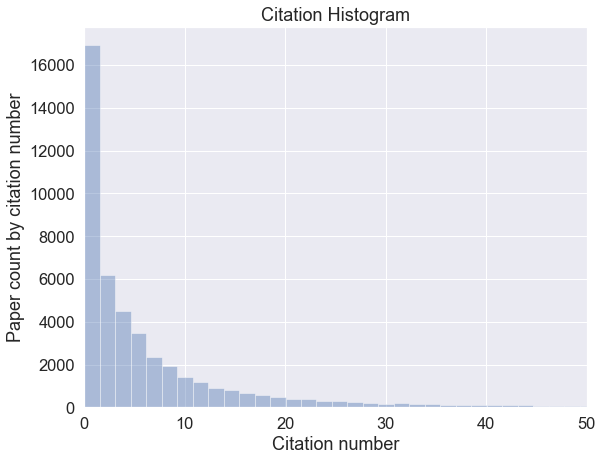

In [69]:
import seaborn as sns
size = (9, 7)
citedDist = sns.distplot(x = df['cites_per_year'],bins = 1000, kde = False) #######
citedDist.set(xlim = (0,50))
citedDist.set_title(label = 'Citation Histogram')        
citedDist.set(ylabel='Paper count by citation number')
citedDist.set(xlabel='Citation number')
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)

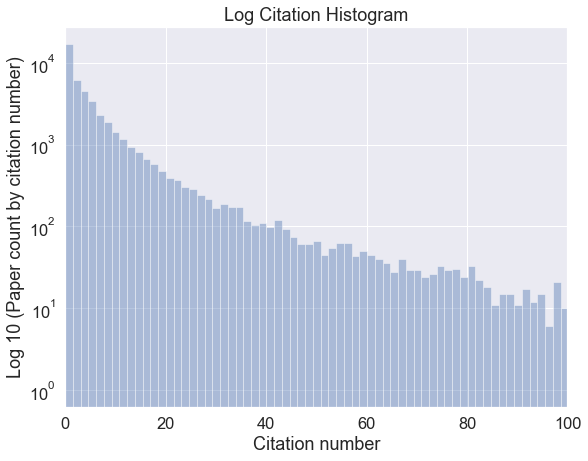

In [70]:
import seaborn as sns
size = (9, 7)
citedDist = sns.distplot(x = df['cites_per_year'],bins = 1000, kde = False) #######
citedDist.set(xlim = (0,100))
citedDist.set_title(label = 'Log Citation Histogram')        
citedDist.set(ylabel='Log 10 (Paper count by citation number)')
citedDist.set_yscale("log")
citedDist.set(xlabel='Citation number')
sns.set(rc={'figure.figsize':(size)})
sns.set(font_scale=1.5)

Articles before a certain time are used as the training set, and articles after a certain time are used as the validation / test set. This mimics the models goal of predicting future citations from past data.

The meta data is one hot encoded using varying methodolgies for each category of metadata. These binarized factors are
then merged into a single sparse X matrix. Truncated SVD is performed to reduce the number of dimensions to a more
managable amount and combine colinear variables.
A sklearn transformer was used as a container for individual transformers specific to each metadata feild, this is shown below

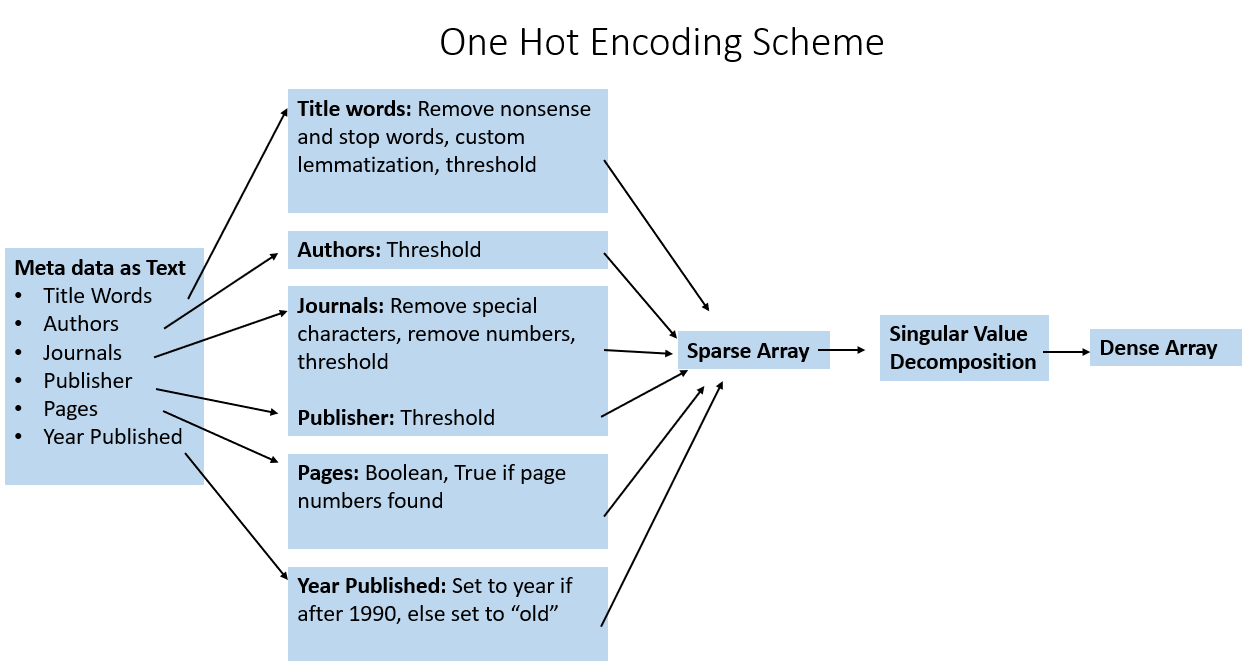

In [73]:
Image(filename='images\\one hot encoding.png') 

In [15]:
import pandas as pd
import numpy as np
import scipy.sparse
from scipy.sparse import coo_matrix, lil_matrix
from sklearn import base

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from typing import Tuple
from sklearn.metrics import classification_report,confusion_matrix

import xgboost as xgb
#from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [16]:
#import all functions needed to fit the pipe
import sys


sys.path.insert(1, os.getcwd() + '//data_cleaning_and_analysis//')
from one_hot_encode_transform_and_fit_old import *

#https://stackoverflow.com/questions/4383571/importing-files-from-different-folder

load the data, pipe, and call predict


### Estimators and Transformers Used in Pipeline
Each meta data feild is treated seperately with it's own transformer. These transformers are placed in the MainTransfomer shown below

In [97]:
class MainTransformer(base.BaseEstimator, base.TransformerMixin):
    ''' Contains transformers which process input data into one hot encoded sparse matrix to be passed to 
        svd and / or an ML model.
    
    '''
    def __init__(self, transformers: dict):
        '''
            transformers
            ----------
            transformers : dict
                Contains transformer objects, objects need be have been initiaized before being passed to MainTransformer.

            Returns
            -------
            None, the estimators and transformers are modified.
        '''
        self.transformers_present = set(transformers.keys())
        self.transformers = transformers

        
    def fit(self, df, y = None):
        '''
            Parameters
            ----------
            df : pd.DataFrame
                df with columns correspdoning to each category of meta data. Must be sorted in ascedning order by date

            Returns
            -------
            None, the estimators and transformers are modified.
        '''
        
        
        for transformer_key in self.transformers.keys():
            print('started fiting ' + transformer_key)
            self.transformers[transformer_key].fit(df)
            
        return self
        
    def transform(self, df, y = None):
        '''
            Parameters
            ----------
            df : pd.DataFrame
                df with columns correspdoning to each category of meta data. Must be sorted in ascedning order by date

            Returns
            -------
            pd.DataFrame, sparse. One hot encoded sparse data frame.
        '''
        count = 0
        for transformer in self.transformers_present:
            print('started transforming ' + transformer)
            if count == 0:
                sparse_df = self.transformers[transformer].transform(df)
                count += 1
            else:
                sparse_df = sparse_df.join(self.transformers[transformer].transform(df), \
                                            lsuffix='_left', rsuffix='_right')
            
        return sparse_df

In [18]:
# An example of the indivual transformers contained in MainTransformer is shown below

In [19]:
class TitleTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        self.title_words = None
        self.synonyms = None
    
    def fit(self, df, y = None):
        
        df['titleID_list'] = str_col_to_list_par(" ", df['titleID'])
        df['titleID_list'] = df['titleID_list'].apply(lambda x: make_lower(x))
        df['titleID_list'] = df['titleID_list'].apply(lambda x:  custom_clean_tokens(x)) # removing nonesense and stopwords
        self.title_words = get_all_cat(df['titleID_list'])
        self.synonyms = buildCustomLookup(self.title_words) # getting custom lemma, this is pretty slow
        self.title_words = remove_synonym(self.title_words, self.synonyms) # filter out synomyms
        df['titleID_list2'] = merge_synonym_par(self.synonyms, df['titleID_list']) # apply custom lemmatization
        title_words_df = one_hot_encode_multi(self.title_words, df['titleID_list2'])# ohe
        title_words_df = threshold_sparse_df(title_words_df, 20) # thresholding using sparse pandas operations
        self.title_words = set(title_words_df.columns)
        print('fit title transformer')
        return self

    def transform(self, df, y = None):

        df['titleID_list'] = str_col_to_list_par(" ", df['titleID'])
        df['titleID_list'] = df['titleID_list'].apply(lambda x: make_lower(x))
        df['titleID_list'] = df['titleID_list'].apply(lambda x:  custom_clean_tokens(x))
        df['titleID_list2'] = merge_synonym_par(self.synonyms, df['titleID_list'])
        title_words_df = one_hot_encode_multi(self.title_words, df['titleID_list2'])
        #print('transformed title words')
        return title_words_df

In [20]:
# The estimator used to predict whether or not a paper is important is placed in a wrapper to allow the train test split by
# take to be handled

In [21]:
class runXGBRegress(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, idx):
        self.model = XGBRegressor(objective = "reg:squaredlogerror")
        self.svd = None
        self.keys = None
        self.idx = idx
        
    def fit(self, X, y):
        #X2, y2, keys, idx = fetch_data()
        self.keys = X.index.to_list()
        X = X.sparse.to_coo()
        X = X.tocsr()
        #y = y + 2
        X_train, X_test, y_train, y_test, keys_train, keys_test = manTTS(self.keys, X, y, self.idx)
        self.svd = TruncatedSVD(1000)
        
        #w = y_weight# switched to oversampling
        X_train = self.svd.fit_transform(X_train)
        X_test = self.svd.transform(X_test)
       # X_train, y_train = oversample(X_train, y_train, 'normal')
        
        
        print('explained variance ratio is ' + str(sum(self.svd.explained_variance_ratio_)))
        #data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

        eval_set = [(X_test, y_test)]
        self.model.fit(X_train, y_train, early_stopping_rounds=15,
                          verbose = 2, eval_set = eval_set, eval_metric = "rmsle")
                          # try aucpr
        return self

    def predict(self, X_test, y = None):
        X_test = self.svd.transform(X_test)
        #data_dmatrix_X_test = xgb.DMatrix(data=X_test)
        preds = self.model.predict(X_test)

        
        preds = self.model.predict(X_test)
        

        return preds

In [23]:
# The functionality shown in the transformers / estimators above is wrapped into an skearn pipeline

In [24]:
idx = get_idx_for_year(df, '2019-07-01') # set the cutoff date for train test split

# create an instance of a specfic transformer for each metadata field
transformers_to_use = {'TitleTransformer': TitleTransformer(),\
                       'JournalTransformer': JournalTransformer(),
                       'AuthorIdTransformer': AuthorIdTransformer(),
                       'YearTransformer': YearTransformer(),
                       'PublisherTransformer': PublisherTransformer(),
                       'PageTransformer': PageTransformer(),
                       'AuthorTransformer': AuthorTransformer()}

transformer = MainTransformer(transformers_to_use)

pipe = Pipeline([
    ('main_transformer', transformer),
    ('predictor', runXGBRegress(idx))
])

## Fitting the Model


In [25]:
# fit the pipe (time consuming)
pipe.fit(X = df.copy(), y = y)

started fiting TitleTransformer
fit title transformer
started fiting JournalTransformer
got dummies journal
started fiting AuthorIdTransformer
started fiting YearTransformer
started fiting PublisherTransformer
started fiting PageTransformer
started fiting AuthorTransformer
started transforming TitleTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['"highlights', '"impact', '"stressed"', '0d:', '0~.~', '1.;', '1.‚Äúsolution', '1997', '1999', '1bco', '1ibr~', '1ni', '1pb', '1te', '1ti.', '1t‚Ä≤', '1√°torr', '1‚Äêb:', '1‚Äêb;', '1‚Äêbis', '1‚Äìx', '1‚àíy', '2000', '2001', '2002', '2003', '2004', '2007', '2008', '2009', '2012', '2013', '2015', '2016', '2017', '2018', '2019', '2020', '2agstate', '2ba~', '2cacu~', '2ca~', '2cu', '2cuo~', '2cu~', '2d?', '2d@', '2deg', '2dft', '2d‚Äêhybrid', '2d‚Äêlayered', '2f@', '2femno', '2h@', '2h‚Äìws', '2mn~', '2o~', '2prime:', '2pyz', '2recu', '2sio', '2y~', '2zn', '2‚Äêaryl', '2‚Äêb:', '2‚Äêc:', '2‚Äêdiborin', '2‚Äêpyridyl', '2‚Äêtetrachloroethane', '2‚Äêthiopheneformamidinium‚Äêbased', '2‚Äìag', '2‚Äìau', '2‚Äìbased', '2‚Äìcarbon', '2‚Äìcsi‚Äìfai', '2‚Äìdmso', '2‚Äìgraphene', '2‚Äìmetal', '2‚Äìmethacrylic', '2‚Äìmos', '2‚Äìpolyaniline', '2‚Äìpt@', '2‚Äìreduced', '2‚Äìsno', '2‚Äìx', '2

started transforming AuthorTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) [' (*: these two authors contributed equally)', ' (*equal contributions)', ' * and aleksandra b. djuri≈°ic', ' * and xugang guo*', ' * yudong zhu', ' * ziang wu', ' ...', ' .a.k. thapa', ' 1', ' 1mohamed a. siddig', ' a a. belik', ' a aadhi', ' a abal‚Äôoshev', ' a abbassi', ' a abdelhakim', ' a abdellah', ' a abdon', ' a abokifa', ' a abourriche', ' a abramov', ' a abrikosov', ' a abu omar', ' a adair', ' a afaq', ' a afif', ' a aguardero', ' a agui', ' a ahmed', ' a akay', ' a akhundov', ' a akrap', ' a al choueiry', ' a al-gaferi', ' a al-masoudi', ' a al-saggaf', ' a alanazi', ' a alario-franco', ' a albadri', ' a albert', ' a alberti', ' a alec talin', ' a alegr√≠a', ' a alekou', ' a aleksandrov', ' a ali', ' a aliev', ' a alimkhan', ' a alimoussa', ' a alizadeh', ' a alkaoud', ' a allerman', ' a alofi', ' a alsabah yousef', ' a alsaggaf', ' a alvarez-fernandez', ' a alya

started transforming JournalTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['', '", journal of nanoparticle research', '- march, cape verde', '-oji lietuvos nacionalinƒó fizikos konferencija: programa ir prane≈°im≈≥ tezƒós,  m. bir≈æelio - d., vilnius. vilnius: vilniaus universitetas,', './mcsi..', '[a] Âü∫Á§é„ÉªÊùêÊñô„ÉªÂÖ±ÈÄöÈÉ®ÈñÄ „Éë„É´„Çπ„Éë„ÉØ„ÉºÁ†îÁ©∂‰ºö', '[a] Âü∫Á§é„ÉªÊùêÊñô„ÉªÂÖ±ÈÄöÈÉ®ÈñÄ „Éó„É©„Ç∫„ÉûÁ†îÁ©∂‰ºö', '[pdf] from ieee.org', '[pdf] from researchgate.net', '[pdf] from yu.edu.jo', '[ÂÖ®ÂõΩÂ§ß‰ºö] Âπ≥Êàê  Âπ¥ÈõªÊ∞óÂ≠¶‰ºöÂÖ®ÂõΩÂ§ß‰ºöË´ñÊñáÈõÜ', 'a theoretical study of carbon-based functionalized materials', 'a. journal of renewable and sustainable energy', 'aaps pharmscitech', 'abstr. pap. am. chem. soc.', 'abstracts of spring meeting of the japan society of powder and powder metallurgy,', 'abstracts/pancreatology', 'acs appl. energy mater', 'acs appl. energy mater.', 'acs appl. mater. inter.', 'acs appl. mater. interfaces,', 'acs app

started transforming PublisherTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['(Society For Science And Nature (SFSN', '10.1007/s12274-017-1896-5', '10.1039/C9CC00472F', '10.29363/nanoge.iperop.2019.077', '10.36478/rjasci.2018.358.362', '10.4229/35thEUPVSEC20182018-1CV.4.78', '10.4229/EUPVSEC20162016-3DV.2.18', '2016 ÎØ∏Íµ≠ MRS ÌïôÌöå', '2017 Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim', '2018 WILEY‚ÄêVCH Verlag GmbH & Co. KGaA, Weinheim', '2019 WILEY‚ÄêVCH Verlag GmbH & Co. KGaA, Weinheim', '30th European Conference on Surface Science (ECOSS-30)', '36th European Photovoltaic Solar Energy Conference and Exhibition', '45th World chemistry congress', '4943', '? 2019 The Minerals, Metals & Materials Society', 'AAAS', 'ACA', 'ACEPS-9 Secretariat', 'ACM', 'ACS American Chemical Society', 'ACS PUBLICATION', 'ACS publications', 'ACS publisher', 'ADVANCED PROCESSES IN MATERIALS', 'AGRI BIO PUBLISHERS INDIA', 'AGU', 'AICHE', 'AIJR Publisher', 'AIP Publishing LLC

started transforming PageTransformer
started transforming AuthorIdTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['-0P8dHAAAAAJ', '-0d5JuIAAAAJ', '-1Pa9F4AAAAJ', '-2idP1UAAAAJ', '-3Qc7_IAAAAJ', '-3UBU_AAAAAJ', '-3sNBB8AAAAJ', '-5gimYgAAAAJ', '-6NMd0wAAAAJ', '-6SIPf8AAAAJ', '-6sOr4oAAAAJ', '-7IzoWAAAAAJ', '-7bd1QsAAAAJ', '-7o9PL8AAAAJ', '-809YacAAAAJ', '-9Gal1kAAAAJ', '-9gDIMQAAAAJ', '-BJJ93UAAAAJ', '-CXRDvEAAAAJ', '-D4NP1kAAAAJ', '-FZCkHkAAAAJ', '-FphqVAAAAAJ', '-G98F50AAAAJ', '-HxjzUYAAAAJ', '-ID-APIAAAAJ', '-IDpYVkAAAAJ', '-IocK10AAAAJ', '-JkVsSMAAAAJ', '-KnIszYAAAAJ', '-Kr_joMAAAAJ', '-LYQr1AAAAAJ', '-OldJb0AAAAJ', '-PSMSh4AAAAJ', '-P_yueAAAAAJ', '-RpXRccAAAAJ', '-RvrkjQAAAAJ', '-SVlsiYAAAAJ', '-SY7iPIAAAAJ', '-TIk5k4AAAAJ', '-USH-SYAAAAJ', '-UVeHGIAAAAJ', '-UxbTBEAAAAJ', '-WguqrMAAAAJ', '-XL0bdIAAAAJ', '-YjbyBYAAAAJ', '-ZVSRr8AAAAJ', '-b7L51MAAAAJ', '-c9ab2oAAAAJ', '-cSYJWUAAAAJ', '-cuycAUAAAAJ', '-dHxodEAAAAJ', '-dw2fOUAAAAJ', '-fXZMr0AAAAJ', '-fdbOysAAAAJ', '-fvE9MAAAAAJ', '-gXe-QE

started transforming YearTransformer
explained variance ratio is 0.5760024706251564
[0]	validation_0-rmsle:1.57173
[2]	validation_0-rmsle:1.29281
[4]	validation_0-rmsle:1.05893
[6]	validation_0-rmsle:0.87897
[8]	validation_0-rmsle:0.75795
[10]	validation_0-rmsle:0.69057
[12]	validation_0-rmsle:0.66214
[14]	validation_0-rmsle:0.65628
[16]	validation_0-rmsle:0.65376
[18]	validation_0-rmsle:0.65175
[20]	validation_0-rmsle:0.64885
[22]	validation_0-rmsle:0.64746
[24]	validation_0-rmsle:0.64689
[26]	validation_0-rmsle:0.64445
[28]	validation_0-rmsle:0.64284
[30]	validation_0-rmsle:0.64310
[32]	validation_0-rmsle:0.64039
[34]	validation_0-rmsle:0.63738
[36]	validation_0-rmsle:0.63718
[38]	validation_0-rmsle:0.63566
[40]	validation_0-rmsle:0.63421
[42]	validation_0-rmsle:0.63384
[44]	validation_0-rmsle:0.63281
[46]	validation_0-rmsle:0.63287
[48]	validation_0-rmsle:0.63167
[50]	validation_0-rmsle:0.63104
[52]	validation_0-rmsle:0.62960
[54]	validation_0-rmsle:0.62921
[56]	validation_0-rmsle:0

Pipeline(steps=[('main_transformer',
                 MainTransformer(transformers={'AuthorIdTransformer': AuthorIdTransformer(),
                                               'AuthorTransformer': AuthorTransformer(),
                                               'JournalTransformer': JournalTransformer(),
                                               'PageTransformer': PageTransformer(),
                                               'PublisherTransformer': PublisherTransformer(),
                                               'TitleTransformer': TitleTransformer(),
                                               'YearTransformer': YearTransformer()})),
                ('predictor', runXGBRegress(idx=40372))])

In [26]:
print('done')

done


In [27]:
# get predictions
df_test = df.iloc[idx:]
y_test = y[idx:]
test_out = pipe.predict(df_test.copy());

started transforming TitleTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['"stressed"', '0d:', '1‚Äìx', '2000', '2019', '2020', '2deg', '2‚Äêb:', '2‚Äêthiopheneformamidinium‚Äêbased', '2‚Äìbased', '2‚Ä≤,', '3dom', '3d‚Äêprinted', '3d‚Äêprinting', '3‚Äêd', '3‚Äìtio', '3‚Äìx', '3‚Äìxbatio', '3‚ÄìŒ¥', '4hcb', '=ca,', 'a3bo', 'aa‚Ä≤bb‚Ä≤o6', 'abatement', 'aberration', 'abinit', 'abnormal', 'abo', 'about', 'absence', 'absences', 'absorb', 'absorptions', 'absorptivity', 'abundant', 'abx', 'abx3', 'abx3‚Äêtype', 'accelerate', 'accelerating', 'acceleration', 'acceptor‚Äìacceptor', 'accessing', 'according', 'account', 'accumulation,', 'accuracy', 'accurately', 'acetaminophen', 'acetic', 'acetone', 'acetonitrile', 'acetylacetonate', 'acetylacetone', 'achievement', 'achromatic', 'acid,', 'acid?', 'acidity', 'acids:', 'acid‚Äêfunctionalized', 'acknowledgement', 'acoustically', 'acridine', 'acrylamide', 'acrylonitrile', 'acta', 'acting', 'action', 'active‚Äêmat

started transforming AuthorTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) [' * and aleksandra b. djuri≈°ic', ' * and xugang guo*', ' * yudong zhu', ' * ziang wu', ' a abourriche', ' a al-saggaf', ' a ali', ' a armbruster', ' a bandyopadhyay', ' a bartolozzi', ' a basaheeh', ' a belfedal', ' a bentayeb', ' a bentouaf', ' a boag', ' a bouhemadou', ' a charkaoui', ' a cheng', ' a chetaine', ' a descoeudres', ' a dess√¨', ' a di vito', ' a efimenko', ' a el tahan', ' a fieramosca', ' a garishvili', ' a gaskov', ' a genco', ' a haq', ' a haruna', ' a hiltunen', ' a howkins', ' a isinhue', ' a isupov', ' a iyo', ' a khanikaev', ' a khayat', ' a laaraibi', ' a lekdadri', ' a liedl', ' a marikutsa', ' a mavrikos', ' a mcclelland', ' a mordini', ' a panagiotopoulos', ' a paulina g√≥mora-figueroa', ' a pushkarev', ' a railanmaa', ' a rastelli', ' a reinhart', ' a rogalev', ' a ron', ' a rosales rivera', ' a saadi', ' a senocrate', ' a sharaiha', ' a sinicropi

started transforming JournalTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) [' th ieee photovoltaic specialists conference (pvsc)', '", journal of nanoparticle research', 'acs appl. energy mater', 'acs appl. mater. interfaces,', 'acs appl. nano mater.', 'acs applied bio materials', 'acs applied polymer materials', 'acs energy letter', 'acs macro letters', 'acs sustainable chem. eng., doi.org/./acssuschemeng.c', 'acta bio medica: atenei parmensis', 'acta phys. pol. a', 'adv. electron. mater', 'adv. funct. mater.', 'adv. mater.', 'advanced energy materials, , vol. , num. , p. ', 'advanced healthcare materials', 'advanced intelligent systems', 'advanced materials doi: ./adma., arxiv:.', 'advanced pharmaceutical bulletin', 'advanced theory and simulations', 'advances in materials physics and chemistry', 'advances in nanoparticles', 'advances in renewable hydrogen and other sustainable energy carriers', 'advances in science, technology and engineering syst

started transforming PublisherTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['2019 WILEY‚ÄêVCH Verlag GmbH & Co. KGaA, Weinheim', 'ACM', 'AGU', 'AMER PHYSICAL SOC', 'APS', 'ASTESJ', 'Americal Chemical Society', 'American Association for The Advancement of Science, Washington, USA', 'American Ceramic Society', 'American Chemical Socienty', 'American Crystallographic Association', 'American Society of Mechanical Engineers Digital Collection', 'Baishideng Publishing Group Inc', 'Budapest University of Technology and Economics, Faculty of Mechanical Engineering, Department of Polymer Engineering', 'Columbia Univ., New York, NY (United States)', 'Cureus Inc.', 'DOI: 10.14704/nq.2020.18.2.NQ20137', 'DOI: 10.4229/EUPVSEC20192019-3BV.2.17', 'DOI: 10.4229/EUPVSEC20192019-3BV.2.8', 'DOI:10.4229/EUPVSEC20192019-3BV.2.17', 'DR-NTU (Data)', 'EDITURA ACAD ROMANE', 'ELSEVIER', 'EPJ Web of Conferences', 'Econjournals', 'Elsevier Ltd', 'Flogen Star Outreach', 'Frontie

started transforming PageTransformer
started transforming AuthorIdTransformer


C:\Users\bcyk5\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:994: UserWarning: unknown class(es) ['-1Pa9F4AAAAJ', '-3Qc7_IAAAAJ', '-6sOr4oAAAAJ', '-7o9PL8AAAAJ', '-9Gal1kAAAAJ', '-BJJ93UAAAAJ', '-FZCkHkAAAAJ', '-HxjzUYAAAAJ', '-JkVsSMAAAAJ', '-KnIszYAAAAJ', '-Kr_joMAAAAJ', '-LYQr1AAAAAJ', '-PSMSh4AAAAJ', '-RpXRccAAAAJ', '-SVlsiYAAAAJ', '-USH-SYAAAAJ', '-UVeHGIAAAAJ', '-b7L51MAAAAJ', '-c9ab2oAAAAJ', '-cSYJWUAAAAJ', '-dw2fOUAAAAJ', '-fvE9MAAAAAJ', '-hG39Q4AAAAJ', '-hxYNJsAAAAJ', '-j7xe_EAAAAJ', '-mO4oVYAAAAJ', '-oZ4CuUAAAAJ', '-qC_RwEAAAAJ', '-w4_7E8AAAAJ', '-xHEehgAAAAJ', '-xR8uNIAAAAJ', '-xwESzoAAAAJ', '0-YFps4AAAAJ', '03mxx6YAAAAJ', '076yjcsAAAAJ', '09xb3kEAAAAJ', '0BrpzAwAAAAJ', '0CXd770AAAAJ', '0Dom3M0AAAAJ', '0GxQN0IAAAAJ', '0Ofj4pEAAAAJ', '0W66KMYAAAAJ', '0XpzFoMAAAAJ', '0iIt2AYAAAAJ', '0kdv3D8AAAAJ', '0onOSscAAAAJ', '0popCNUAAAAJ', '0q1weeYAAAAJ', '0rbX2p8AAAAJ', '0ro-DvoAAAAJ', '0rq0EAkAAAAJ', '0uyQQ28AAAAJ', '0v4F6rEAAAAJ', '0v7RDdkAAAAJ', '0v84rUgAAAAJ', '11rZNqs

started transforming YearTransformer


## Evaluate Model Performance

The functions below sort the predictions and make plots of how many items were correctly predicted to be in the top quantile. For a given qunatile (top 2%, 5%, 10% etc) how many papers did the model get right? As long as those papers appear in the right quantile, the relative rank is not used.

In [29]:
def make_fraction_set_as_important_correctly(res_df, upper_thresh):
    # plot how many papers were correctly classified as important for a given
    # threshhold of importance
    
    thresholds = [x/100 for x in range(1, upper_thresh, 1)]
    
    res_df = res_df.sort_values(by = 'actual', ascending = False)

    frac_correct = [fraction_correct_and_order_from_df(res_df, x) for x in thresholds]
    return (thresholds, frac_correct)

def package_preds_6_15(idx: int, y_test: np.array, preds: np.array) -> pd.DataFrame:
    # converts y_test and preds to a df with the same indexing as the df 
    # they came from
    index_for_df = np.linspace(idx, idx + len(y_test), len(y_test)).astype(int)
    
    res_df = pd.DataFrame(data = {'actual': y_test, 'preds': preds}, index = index_for_df)
    
    return res_df

def fraction_correct_and_order_from_df(df_in, quantile):
    """ Given index, actual, and predicted, do
        calculate the % got correct for a quantile (eg top 10%)
    """

    # need to get quantiles for actual and predicted
    
    df_top_actual = df_in.iloc[0:int(np.round(len(df_in)*quantile))]
    
    df_in = df_in.sort_values(by = 'preds', ascending = False)
    df_top_preds = df_in.iloc[0:int(np.round(len(df_in)*quantile))]
    
    fraction_correct = len(df_top_preds.merge(df_top_actual)) / len(df_top_actual)
    #print(fraction_correct)
    
    return fraction_correct

In [58]:
# calculating the R Precision metric for several Rs to get a sense of model performance
# https://en.wikipedia.org/wiki/Evaluation_measures_(R percision

res_df = package_preds_6_15(idx, y_test, test_out)
frac_correct_curve = make_fraction_set_as_important_correctly(res_df, 15)

In [59]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Fraction of Total Papers Correctly Placed')

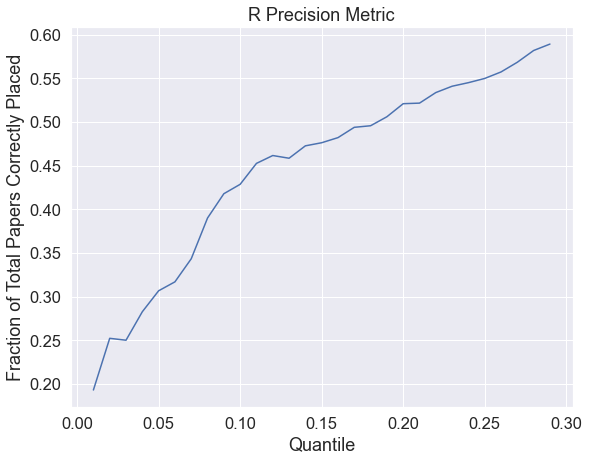

In [99]:
plt.plot(frac_correct_curve[0], frac_correct_curve[1])
plt.title('R Precision Metric')
plt.xlabel('Quantile')
plt.ylabel('Fraction of Total Papers Correctly Placed')

In [94]:
# The model is picking up a signal in the data. The plot above shows the the 
# fraction of papers that were correctly placed in a quantile specified by the x axis.
# For example, if the user reads the top 10% of papers based on the predicted importance, they will have 
# ~43% of papers which were actually in the top 10%